# Global Common Neighors

@cypher:

    CALL gds.graph.create(
    'KG4',
        ["MeSH", "Document", "Protein", "Drug", "Pathway"],
        {
            MENTIONS: {orientation: 'UNDIRECTED'},
            TARGET: {orientation: 'UNDIRECTED'},
            ASSIGNS: {orientation: 'UNDIRECTED'},
            CANDIDATE: {orientation: 'UNDIRECTED'}
        }
    )

In [1]:
from neo4j import GraphDatabase 
import pandas as pd

from itertools import islice
from functools import partial
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(font_scale = 1.5)

### Running Pagerank to Filter Nodes

In [2]:
from neo4j import GraphDatabase

class pagerank:
    def __init__(self) -> None:
        self.driver = GraphDatabase.driver("neo4j://localhost:7687", auth=("neo4j", "heart"))

    def close(self) -> None:
        self.driver.close()


    @classmethod
    def pagerank(cls, tx) -> any:
        """
        @param cls is the class
        @param tx is the transaction
        @return result.data() is the data of the pagerank
        """
        query = ("""
                CALL gds.pageRank.write('KG', {
                writeProperty: 'pagerank'
                })
                YIELD nodePropertiesWritten, ranIterations
        
                """)
        result = tx.run(query)
        return result.data()


    def run_pagerank(self) -> any:
        """
        @param self
        @return result is the dataframe from the pagerank
        """
        result = self.driver.session().write_transaction(self.pagerank)
        result = pd.DataFrame(result)
        return result

In [3]:
hello = pagerank()
result = hello.run_pagerank()

#### Using Link Prediction on Nodes with Pagerank > X

In [4]:
class common_neighbors():
    """Class to run LinkPred"""
    def __init__(self) -> None:
        self.driver = GraphDatabase.driver("neo4j://localhost:7687", auth=("neo4j", "heart"))

    def close(self) -> None:
        self.driver.close()

    @classmethod
    def LinkPred(cls, tx, mesh, protein) -> any:
        """
        @param cls is the class
        @param tx is the transaction
        @return result.data() is the data
        """
        query = ("""
        MATCH (m:MeSH{name: $mesh})
        MATCH (n:Protein{name: $protein})
        RETURN gds.alpha.linkprediction.commonNeighbors(n, m) AS LinkPred_Score
        """)
        result = tx.run(query, mesh = mesh, protein = protein)
        return result.data()

    @classmethod
    def get_nodes(cls, tx) -> any:
        query = ("""
        MATCH (n:Protein {type: "Ion Channel"}) WHERE n.pagerank > 10
        MATCH (m:MeSH) WHERE m.pagerank > 10
        RETURN n.name as Protein, m.name as MeSH
        """)
        result = tx.run(query)
        return result.data()

    def nodes(self) -> pd.DataFrame:
        result = self.driver.session().write_transaction(self.get_nodes)
        result = pd.DataFrame(result)
        return result

    def push(self, df) -> pd.DataFrame:
        ls = []
        print("Iterations:", len(df), flush=True)
        for protein, mesh in tqdm(zip(df["Protein"], df["MeSH"]), desc = "LinkPred"):
            ls.append(self.driver.session().write_transaction(self.LinkPred, mesh, protein))
        df["LinkPred Score"] = ls
        print("Success")
        return df

In [5]:
g = common_neighbors()

In [6]:
df1 = g.nodes()
df1

,Protein,MeSH
0,Amyloid beta A4 protein,cardiomyopathies
1,Amyloid beta A4 protein,"cardiomyopathy, dilated"
2,Amyloid beta A4 protein,"cardiomyopathy, hypertrophic"
3,Amyloid beta A4 protein,myocardial reperfusion injury
4,Amyloid beta A4 protein,myocarditis
...,...,...
295,Cardiac phospholamban,cardiomegaly
296,Cardiac phospholamban,"hypertrophy, left ventricular"
297,Cardiac phospholamban,heart arrest
298,Cardiac phospholamban,"death, sudden, cardiac"


In [7]:
result = g.push(df1)
result

Iterations: 300


LinkPred: 300it [00:01, 264.78it/s]

Success


,Protein,MeSH,LinkPred Score
0,Amyloid beta A4 protein,cardiomyopathies,[{'LinkPred_Score': 17.0}]
1,Amyloid beta A4 protein,"cardiomyopathy, dilated",[{'LinkPred_Score': 8.0}]
2,Amyloid beta A4 protein,"cardiomyopathy, hypertrophic",[{'LinkPred_Score': 9.0}]
3,Amyloid beta A4 protein,myocardial reperfusion injury,[{'LinkPred_Score': 8.0}]
4,Amyloid beta A4 protein,myocarditis,[{'LinkPred_Score': 0.0}]
...,...,...,...
295,Cardiac phospholamban,cardiomegaly,"[{'LinkPred_Score': 56.0}, {'LinkPred_Score': ..."
296,Cardiac phospholamban,"hypertrophy, left ventricular","[{'LinkPred_Score': 18.0}, {'LinkPred_Score': ..."
297,Cardiac phospholamban,heart arrest,"[{'LinkPred_Score': 5.0}, {'LinkPred_Score': 4..."
298,Cardiac phospholamban,"death, sudden, cardiac","[{'LinkPred_Score': 3.0}, {'LinkPred_Score': 2..."


In [8]:
for i in tqdm(range(len(result))):
    result["LinkPred Score"][i] = result["LinkPred Score"][i][0]["LinkPred_Score"]

result

100%|██████████| 300/300 [00:00<00:00, 3409.18it/s]


,Protein,MeSH,LinkPred Score
0,Amyloid beta A4 protein,cardiomyopathies,17.0
1,Amyloid beta A4 protein,"cardiomyopathy, dilated",8.0
2,Amyloid beta A4 protein,"cardiomyopathy, hypertrophic",9.0
3,Amyloid beta A4 protein,myocardial reperfusion injury,8.0
4,Amyloid beta A4 protein,myocarditis,0.0
...,...,...,...
295,Cardiac phospholamban,cardiomegaly,56.0
296,Cardiac phospholamban,"hypertrophy, left ventricular",18.0
297,Cardiac phospholamban,heart arrest,5.0
298,Cardiac phospholamban,"death, sudden, cardiac",3.0


In [19]:
#result.to_csv("LinkPred.csv")

In [9]:
protein = result["Protein"].unique()
mesh = result["MeSH"].unique()
print(len(result["Protein"].unique()))

14


In [17]:
matrix = []
ls = []
for i in result.iterrows():
    for x in protein:
        for y in mesh:
            if x == i[1]["Protein"] and y == i[1]["MeSH"]:
                ls.append(i[1]["LinkPred Score"])

size = 20
matrix = list(iter(partial(lambda it: tuple(islice(it, size)), iter(ls)), ()))
matrix = matrix[:-1]

#### Graphing using Seaborn

Text(120.45312499999999, 0.5, 'Ion Channel Proteins')

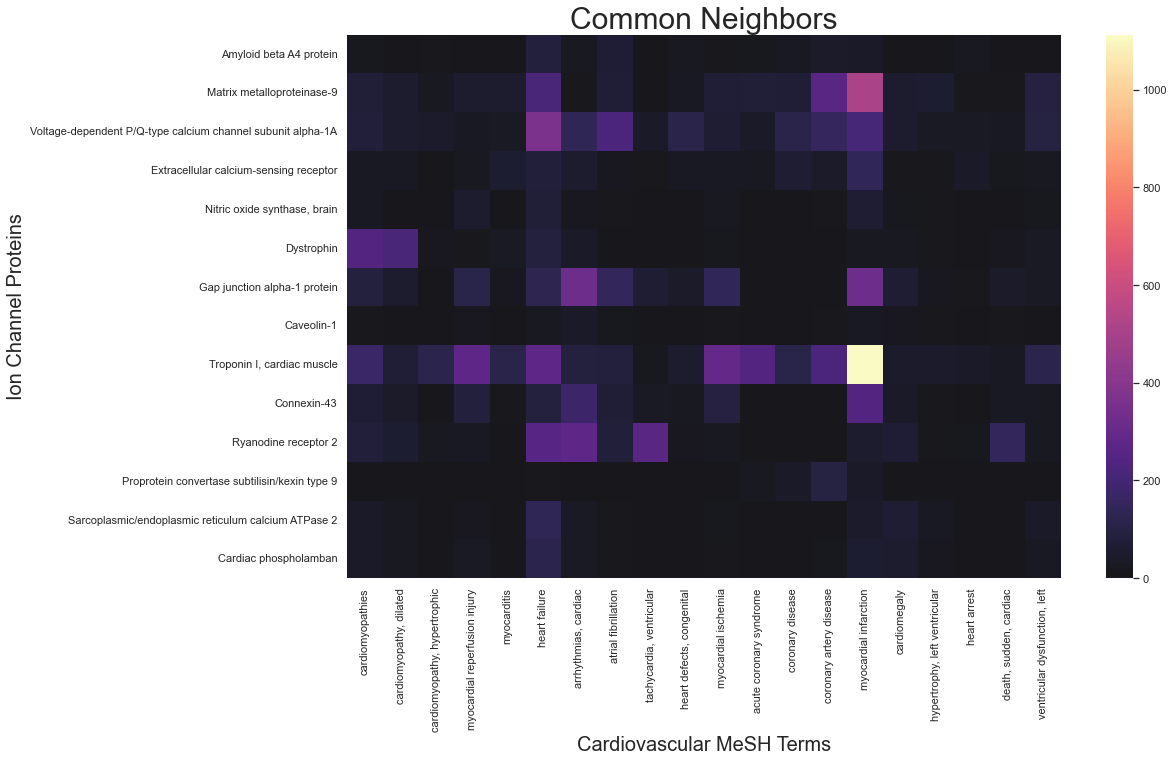

In [30]:
plt.figure(figsize=(16,10))
sns.set_theme()
ax = sns.heatmap(data = matrix, alpha=0.9, cmap = "magma", yticklabels = protein, xticklabels = mesh)
plt.title("Common Neighbors",  fontdict={'fontsize':30})
plt.xlabel("Cardiovascular MeSH Terms", fontdict={'fontsize':20})
plt.ylabel("Ion Channel Proteins", fontdict={'fontsize':20})